# Feature Engineering

## 1. Mutual information

**Mutual information** is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while **correlation** only detects linear relationships.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

pd.plotting.register_matplotlib_converters()
%matplotlib inline
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

def score_dataset(X, y, model=LinearRegression()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [39]:
accidents = pd.read_csv("fe_data/accidents.csv")
autos = pd.read_csv("fe_data/autos.csv")
concrete = pd.read_csv("fe_data/concrete.csv")
customer = pd.read_csv("fe_data/customer.csv")
ames = pd.read_csv("fe_data/ames.csv")

autos.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


In [41]:
X = autos.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
# As a rule of thumb, anything that must have a float dtype is not discrete. 
# Categoricals (object or categorial dtype) can be treated as discrete by giving them a label encoding. 

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [42]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

curb_weight          1.504602
highway_mpg          0.948731
length               0.611628
bore                 0.492114
stroke               0.388129
num_of_cylinders     0.331096
compression_ratio    0.133349
fuel_type            0.048139
Name: MI Scores, dtype: float64

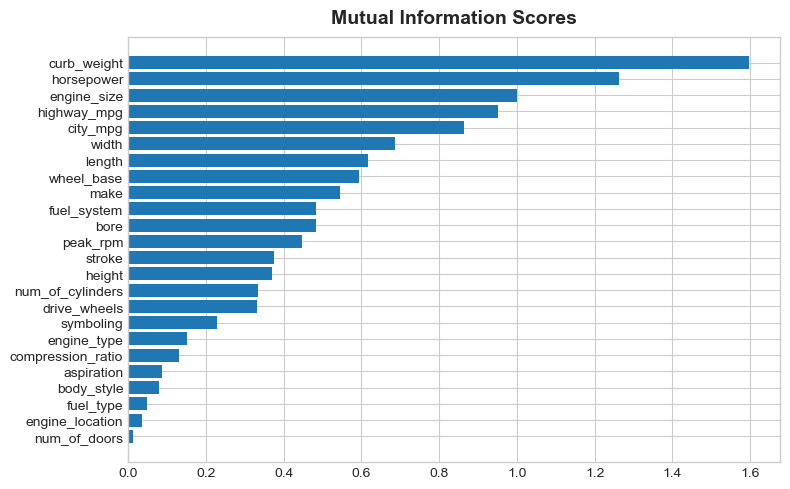

In [49]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

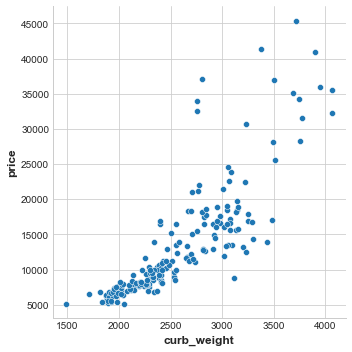

In [50]:
sns.relplot(x="curb_weight", y="price", data=df);

The `fuel_type` feature has a fairly low MI score, but as we can see from the figure, it clearly separates two `price` populations with different trends within the `horsepower` feature. This indicates that `fuel_type` contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

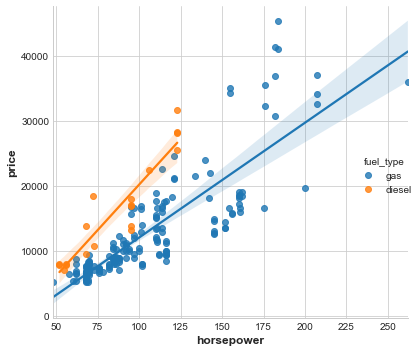

In [52]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

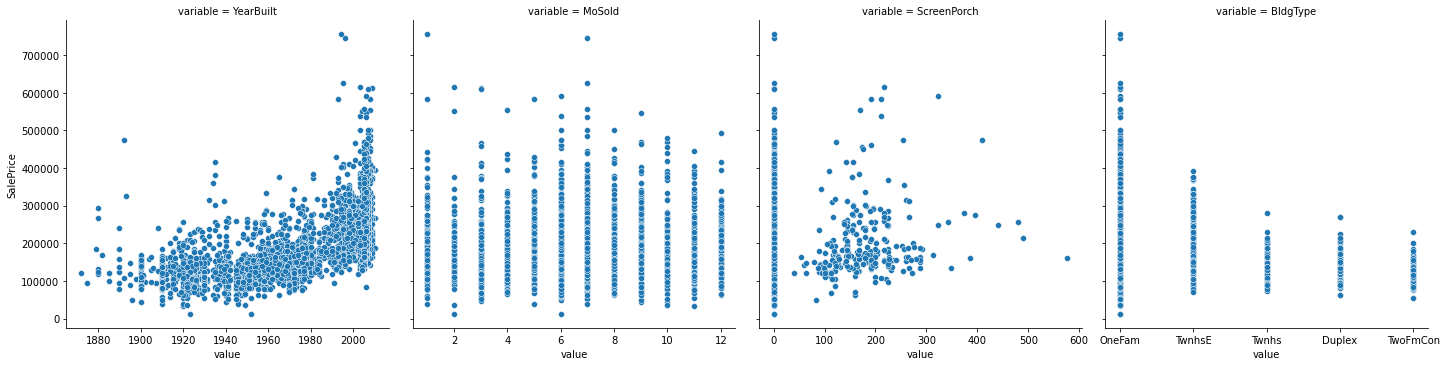

In [18]:
# Load data
df = pd.read_csv("fe_data/ames.csv")

features = ["YearBuilt", "MoSold", "ScreenPorch", 'BldgType']
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

X = df.copy()
y = X.pop('SalePrice')

# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [10]:
mi_scores = make_mi_scores(X, y)

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64


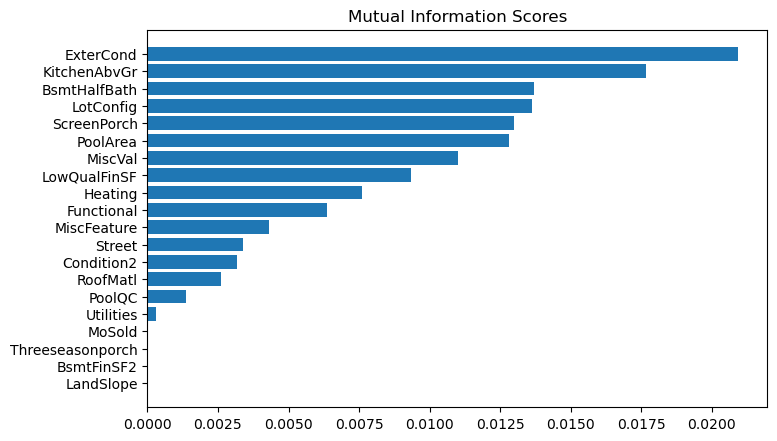

In [19]:
print(mi_scores.head(20))
#print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
#plot_mi_scores(mi_scores.head(20))
plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

In [30]:
mi_scores.value_counts(bins=10, sort=True, ascending=True)

(0.465, 0.523]          1
(0.407, 0.465]          2
(0.523, 0.581]          2
(0.291, 0.349]          3
(0.349, 0.407]          4
(0.233, 0.291]          5
(0.116, 0.174]          7
(0.174, 0.233]          8
(0.0581, 0.116]        12
(-0.001581, 0.0581]    34
Name: MI Scores, dtype: int64

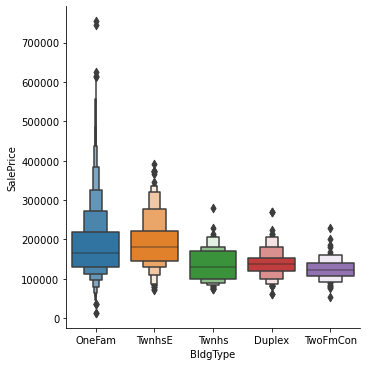

In [13]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");

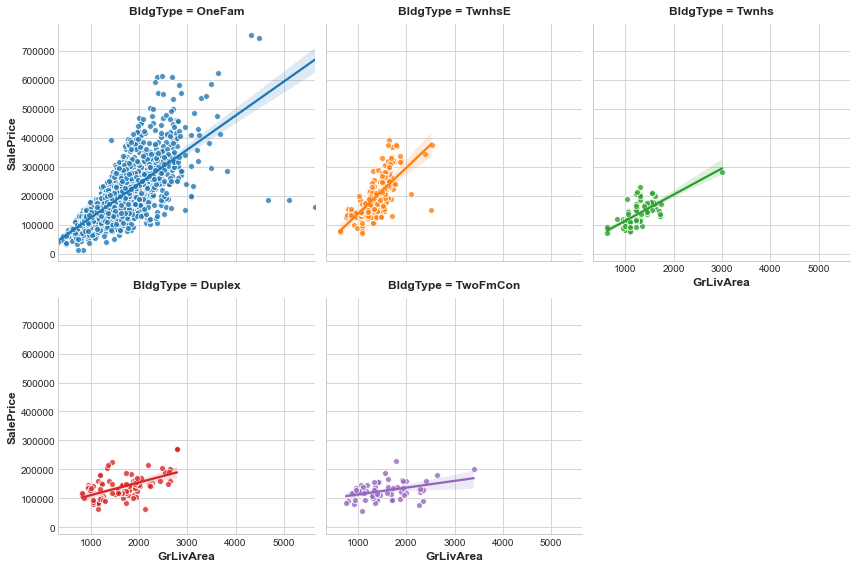

In [44]:
# YOUR CODE HERE: 
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

## 2. Creating Features

### Mathematical Transforms

In [65]:
autos["stroke_ratio"] = autos.stroke / autos.bore

autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


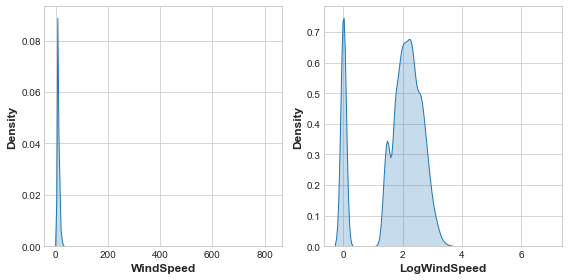

In [54]:
# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1]);

### Counts

In [7]:
# In Traffic Accidents are several features indicating 
# whether some roadway object was near the accident.
# This will create a count of the total number of roadway
# features nearby using the sum method:`

roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


In [9]:
# In the Concrete dataset are the amounts of components
# in a concrete formulation. Many formulations lack one 
# or more components (that is, the component has a value of 0).
# This will count how many components are in a formulation
# with the dataframe's built-in greater-than gt method:

components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]
concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


### Building-Up and Breaking-Down Features

Often you'll have complex strings that can usefully be broken into simpler pieces. Some common examples:

- ID numbers: `'123-45-6789'`
- Phone numbers: `'(999) 555-0123'`
- Street addresses: `'8241 Kaggle Ln., Goose City, NV'`
- Internet addresses: `'http://www.kaggle.com`
- Product codes: `'0 36000 29145 2'`
- Dates and times: `'Mon Sep 30 07:06:05 2013'`

Features like these will often have some kind of structure that you can make use of. US phone numbers, for instance, have an area code (the '(999)' part) that tells you the location of the caller. As always, some research can pay off here.

In [64]:
customer[["Type", "Level"]] = (  # Create two new features
    customer["Policy"]           # from the Policy feature
    .str                         # through the string accessor
    .split(" ", expand=True)     # by splitting on " "
                                 # and expanding the result into separate columns
)

customer[["Policy", "Type", "Level"]].head(10)

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1
5,Personal L3,Personal,L3
6,Corporate L3,Corporate,L3
7,Corporate L3,Corporate,L3
8,Corporate L3,Corporate,L3
9,Special L2,Special,L2


In [71]:
# You could also join simple features into
# a composed feature if you had reason to 
# believe there was some interaction in the combination:

autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].head()

,make,body_style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan


## Clustering With K-Means

You may need to increase the `max_iter` for a large number of clusters or `n_init` for a complex dataset. Ordinarily though the only parameter you'll need to choose yourself is `n_clusters` (k, that is). The best partitioning for a set of features depends on the model you're using and what you're trying to predict, so it's best to tune it like any hyperparameter (through cross-validation, say).

In [29]:
X = ames.copy()
y = X.pop("SalePrice")


# YOUR CODE HERE: Define a list of the features to be used for the clustering
features = ['LotArea', 'TotalBsmtSF', 'FirstFlrSF','SecondFlrSF', 'GrLivArea']


# Standardize
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)


# YOUR CODE HERE: Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(10, random_state=0)
X["Cluster"] = kmeans.fit_predict(X_scaled)


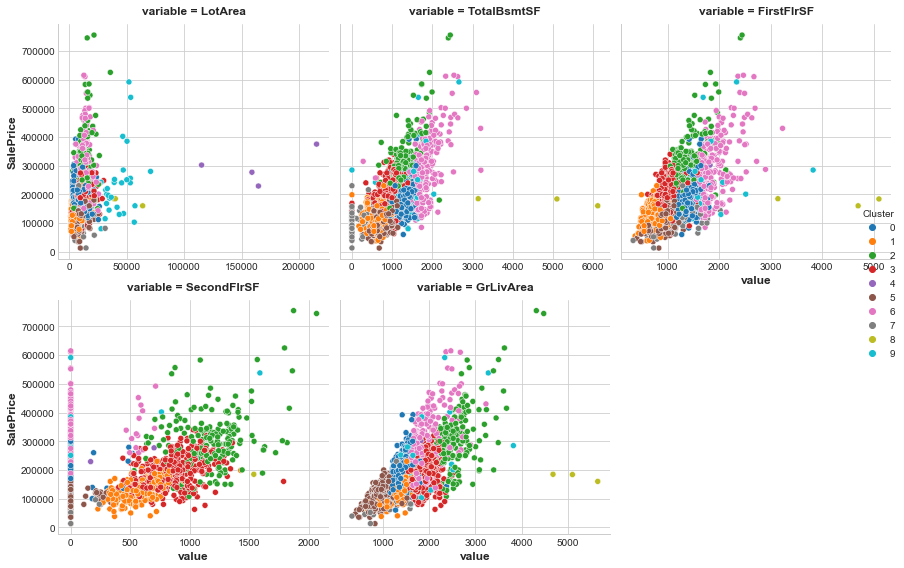

In [30]:
Xy = X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=features, id_vars=["SalePrice", "Cluster"],
    ),
);

In [31]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)


# YOUR CODE HERE: Create the cluster-distance features using `fit_transform`
X_cd = kmeans.fit_transform(X_scaled)


# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)
